In [1]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
from pprint import pprint

from earthpy.spatial import stack as es_stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce

# mapping
import cartopy
import cartopy.crs as ccrs

from matplotlib import colors
import matplotlib.gridspec as gridspec

import pandas as pd
import calendar
import imageio # animation
from helpers import *
from affine import Affine
from pylab import *

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('font',**{'family':'serif','serif':['Arial']})
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})


# write out the rasters
def write_out(xarr, fname, meta_file):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None

def write_out_agg(xarr, fname, meta_file, agg=0.25):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    if agg != 0.25:

        # restructure affine
        orig_size = meta['transform'].a
        agg_size = agg
        factor = agg_size/orig_size

        # calculate the new rows/cols
        new_height = int(np.floor_divide(meta['height'], factor))
        new_width = int(np.floor_divide(meta['width'], factor))

        # calculate the new center point for the upper left
        new_ul_x = meta['transform'].c - orig_size + agg_size/2
        new_ul_y =  meta['transform'].f + orig_size - agg_size/2

        # generate the new transform
        new_transform = Affine(agg_size, 0.0, new_ul_x, 
                               0.0, -agg_size, new_ul_y)

        # dictionary to update the metadata
        update_dict = {'height': new_height,
                       'width': new_width,
                      'transform': new_transform}

        meta.update(update_dict)

    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None



PyTables is not installed. No support for HDF output.


In [2]:
raster_folder = '../vars_refresh_may2021/CSV_nocorn_grid_0_25_degree_vars/'
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]

with rio.open('../vars/aqua-terra-overpasses-per-day_0.25-degree-grid.tif') as src:
    op_0_25 = src.read()[0]
    print(src.profile)
    
    op_0_25[op_0_25<=0] = 1
    op_0_25_prof = src.profile

with rio.open('../vars/aqua-terra-overpasses-per-day_2.5-degree-grid.tif') as src:
    op_0_2_5 = src.read()[0]
    print(src.profile)
    
    op_0_2_5[op_0_2_5<=0] = 1

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 144, 'height': 72, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.5, 0.0, -178.875,
       0.0, -2.5, 88.875), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [3]:
days_fl, nights_fl=[],[]
day_an, night_an = [],[]
agg = 4
for year in range(2003,2021):

    day_files = glob(raster_folder + f'{var}/*_D_*{year}.tif')
    night_files = glob(raster_folder + f'{var}/*_N_*{year}.tif')
    
    day_arr,_ = es_stack(day_files, nodata=-32768)
    night_arr, _ = es_stack(night_files, nodata=-32768)
    op_oc = np.ma.masked_equal(op_0_25*365.25/2, 0) # annual overpass average
    
    #day_an.append(day_arr*op_oc)
    #night_an.append(night_arr*op_oc)
    
#     print(day_arr.shape)
#     print((np.ma.sum(day_arr, axis=0)*op_oc).shape)
    
    ds = np.ma.sum(day_arr, axis=0)/op_oc
    ns = np.ma.sum(night_arr, axis=0)/op_oc
    
    day_an.append(ds[np.newaxis,...])
    night_an.append(ns[np.newaxis, ...])
    
    #day_an.append(np.ma.sum(day_arr, axis=0)*op_oc)
    #night_an.append(np.ma.sum(night_arr, axis=0)*op_oc)
    
    # they are different...
    #print(np.ma.mean(day_arr*op_oc - night_arr*op_oc))
    
    continue

In [4]:
# day_sum = np.ma.concatenate(day_an, axis=0).sum(axis=0)
# night_sum = np.ma.concatenate(night_an, axis=0).sum(axis=0)

day_sum = np.ma.concatenate(day_an, axis=0)
print(day_sum.shape)
day_sum = np.ma.sum(day_sum, axis=0)
night_sum = np.ma.concatenate(night_an, axis=0)
night_sum = np.ma.sum(night_sum, axis=0)


perc_day_total = day_sum / (day_sum + night_sum)
perc_night_total = night_sum / (day_sum + night_sum)

(18, 721, 1440)


In [5]:
folder = '../mcd14ml_solar-elevation-angle/'
folder = '../mcd14ml_analysis-ready/' # june 2021 update
csv_files = glob(folder + '*.csv')

day_counts = []
night_counts = []
nperc_ds = []
nct_ds = []
dct_ds = []
for csvfi in csv_files[3:-1]:
    
    year = int(os.path.basename(csvfi).split('_')[-1].split('.')[0])
    print(f'on year {year}')
    
    
    _df = pd.read_csv(csvfi)
    _df = _df.loc[(_df['confidence'] > 10) & (_df['type'] == 0)]
    
    #reassign daynight based on solar elevation
    og_day_cts = _df.loc[_df['daynight']=='D'].shape[0]
    og_night_cts = _df.loc[_df['daynight']=='N'].shape[0]
    
    _df.loc[_df['solar_ang'] < 0, 'daynight'] = 'N'
    _df.loc[_df['solar_ang'] > 0, 'daynight'] = 'D'
    
    rc_day_cts = _df.loc[_df['daynight']=='D'].shape[0]
    rc_night_cts = _df.loc[_df['daynight']=='N'].shape[0]
    
    print(f'# misclassified day: {rc_day_cts - og_day_cts}')
    print(f'# misclassified night: {rc_night_cts - og_night_cts}')
    
#     print(f'total day cts for {year}: {rc_day_cts}')
#     print(f'total night cts for {year}: {rc_night_cts}')
    
    day_counts.append(rc_day_cts)
    night_counts.append(rc_night_cts)
    
    # group by latitude single degree
    _df['round_lat'] = np.floor(_df['latitude'])
    _day = _df.loc[_df['daynight']=='D'].groupby('round_lat').count()
    _night = _df.loc[_df['daynight']=='N'].groupby('round_lat').count()
    
    _day_count = _day['frp']
    _night_count = _night['frp']
    nperc = _night_count / (_night_count + _day_count)
    nperc_ds.append(nperc)
    nct_ds.append(_night_count)
    dct_ds.append(_day_count)

on year 2003
# misclassified day: 12600
# misclassified night: -12600
on year 2004
# misclassified day: 20603
# misclassified night: -20603
on year 2005
# misclassified day: 12003
# misclassified night: -12003
on year 2006
# misclassified day: 5010
# misclassified night: -5010
on year 2007
# misclassified day: 3051
# misclassified night: -3051
on year 2008
# misclassified day: 4881
# misclassified night: -4881
on year 2009
# misclassified day: 10448
# misclassified night: -10448
on year 2010
# misclassified day: 12524
# misclassified night: -12524
on year 2011
# misclassified day: 6473
# misclassified night: -6473
on year 2012
# misclassified day: 22498
# misclassified night: -22498
on year 2013
# misclassified day: 16696
# misclassified night: -16696
on year 2014
# misclassified day: 16952
# misclassified night: -16952
on year 2015
# misclassified day: 9387
# misclassified night: -9387
on year 2016
# misclassified day: 16534
# misclassified night: -16534
on year 2017
# misclassified d

In [6]:
day_cts_arr = np.array(day_counts)
night_cts_arr = np.array(night_counts)

print(f'total nighttime count percentage: {night_cts_arr.sum() / (night_cts_arr.sum() + day_cts_arr.sum()) *100: .2f}%')
print(f'total nighttime counts: {night_cts_arr.sum()}')
print(f'total daytime counts: {day_cts_arr.sum()}')
print(f'annual average % of nighttime counts: {(night_cts_arr / (night_cts_arr + day_cts_arr)).mean()*100:.2f}%')
print(f'annual std % of nighttime counts: {(night_cts_arr / (night_cts_arr + day_cts_arr)).std()*100:.2f}%')

total nighttime count percentage:  10.38%
total nighttime counts: 7883986
total daytime counts: 68055009
annual average % of nighttime counts: 10.36%
annual std % of nighttime counts: 0.93%


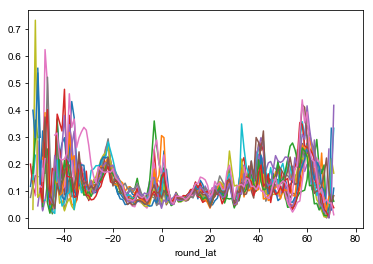

([0.14283034150481277,
  0.11349598493166098,
  0.12650473183463712,
  0.123342063859377,
  0.13105141188814728,
  0.11388385741866922,
  0.12331270892274236,
  0.12700476936642158,
  0.1190171908898327,
  0.13766153140353052,
  0.12334413071730893,
  0.12349600116213251,
  0.1245082040660667,
  0.12826292424549798,
  0.14296785066768578,
  0.1331692016044712,
  0.15867011827857364],
 0.12897194251538635)

In [7]:
[_.shape for _ in nperc_ds]

fig, ax = plt.subplots()
[_.plot(ax=ax) for _ in nperc_ds]
plt.show()

[_.mean() for _ in nperc_ds], np.mean([_.mean() for _ in nperc_ds])

(<matplotlib.axes._subplots.AxesSubplot at 0x20aa6983a90>, 0.13512007224911016)

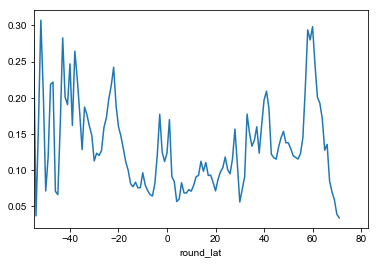

In [8]:
n_df = pd.DataFrame(nct_ds).T.sum(axis=1)
d_df = pd.DataFrame(dct_ds).T.sum(axis=1)
perc_night_cts = n_df.fillna(0) / (n_df.fillna(0) + d_df.fillna(0))

perc_night_cts.plot(), perc_night_cts.mean()

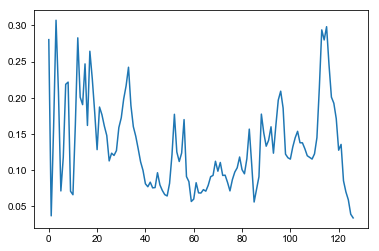

In [9]:
plt.plot(perc_night_cts.values)

In [10]:
perc_night_total.mean()

0.12931286433552464

In [11]:
# group by latitude single degree
_df['round_lat'] = np.floor(_df['latitude'])
_day = _df.loc[_df['daynight']=='D'].groupby('round_lat').count()
_night = _df.loc[_df['daynight']=='N'].groupby('round_lat').count()

(<matplotlib.axes._subplots.AxesSubplot at 0x20aa6a27160>, 0.15867011827857364)

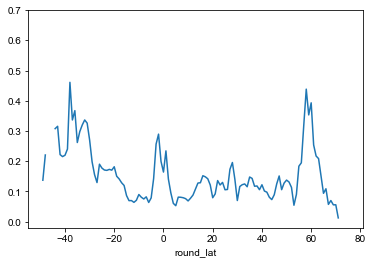

In [12]:
_day_count = _day['frp']
_night_count = _night['frp']
nperc = _night_count / (_night_count + _day_count)

nperc.plot(), nperc.mean()

## Plot by Longitude

In [13]:
# to sum by latitude, sum across the columns


In [14]:
day_sum_lat = day_sum.filled(0).sum(axis=1)
night_sum_lat = night_sum.filled(0).sum(axis=1)

day_sum_lat = np.ma.sum(day_sum, axis=1)
night_sum_lat = np.ma.sum(night_sum, axis=1)

# day_sum_lat = np.ma.masked_equal(day_sum_lat, 0)
# night_sum_lat = np.ma.masked_equal(night_sum_lat, 0)
day_sum_lat.shape, type(day_sum_lat)

((721,), numpy.ma.core.MaskedArray)

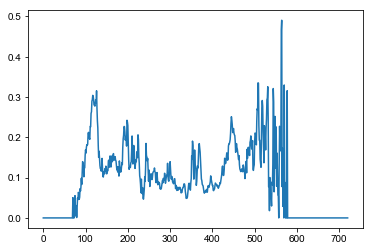

In [15]:
perc_night_lat = night_sum_lat / (night_sum_lat + day_sum_lat)

perc_night_lat = np.ma.MaskedArray(perc_night_lat, mask=np.isnan(perc_night_lat))

plt.plot(perc_night_lat.filled(0))

In [16]:
#plt.plot(np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

In [17]:
tform = op_0_25_prof['transform']
ncols = op_0_25_prof['width']
nrows = op_0_25_prof['height']

In [18]:
lons = np.arange(tform.f , -tform.f + tform.e, tform.e) 
lons.max(), lons.min()

lons=lons[..., np.newaxis]
perc_night_lat=perc_night_lat[...,np.newaxis]

# apply perc_night_lat mask to lons
lons_ma = np.ma.MaskedArray(lons, mask=perc_night_lat.mask[:-1])

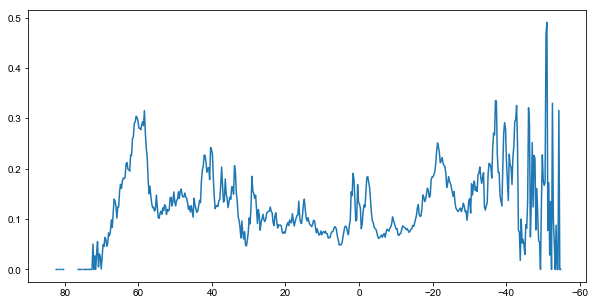

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
# plt.plot(lons, perc_night_lat)
ax.plot(lons_ma, perc_night_lat[:-1])
ax.invert_xaxis()
plt.show()

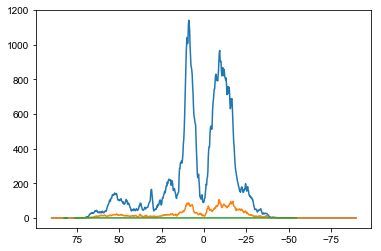

Text(0, 0.5, '% Nighttime Detections')

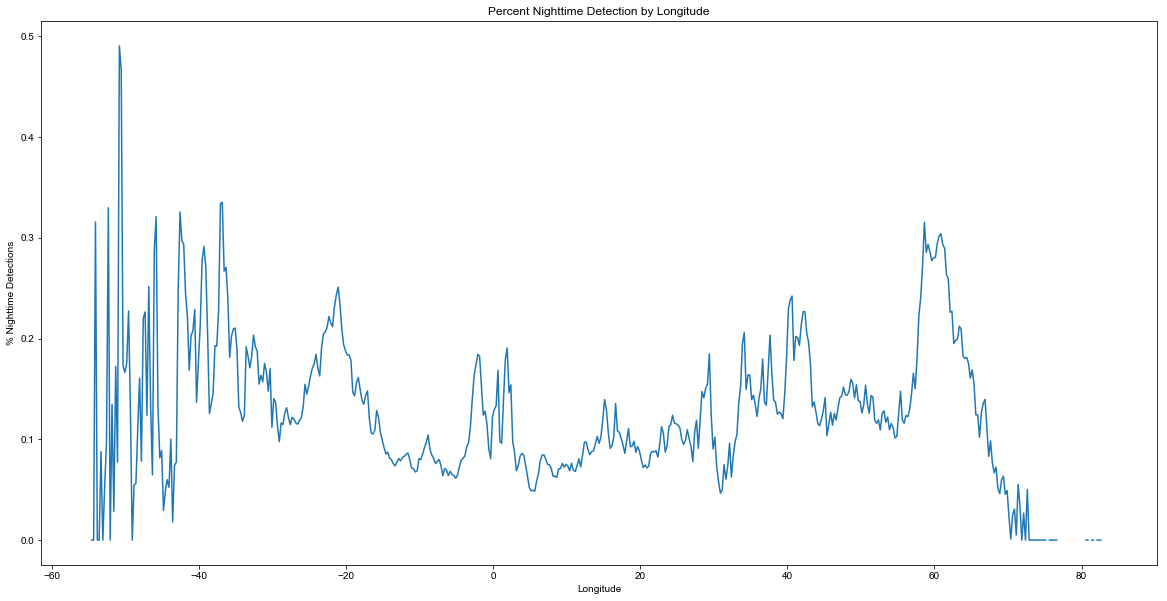

In [20]:
fig, ax = plt.subplots()
ax.plot(lons, day_sum_lat[1:])
ax.plot(lons, night_sum_lat[1:])
night_perc = night_sum_lat / (day_sum_lat + night_sum_lat)
ax.plot(lons, night_perc[1:])
ax.invert_xaxis()
plt.show()


fig, ax = plt.subplots(figsize=(20,10))
night_perc = night_sum_lat / (day_sum_lat + night_sum_lat)
ax.plot(lons, night_perc[1:])
# ax.invert_xaxis()
plt.title('Percent Nighttime Detection by Longitude')
ax.set_xlabel('Longitude')
ax.set_ylabel('% Nighttime Detections')

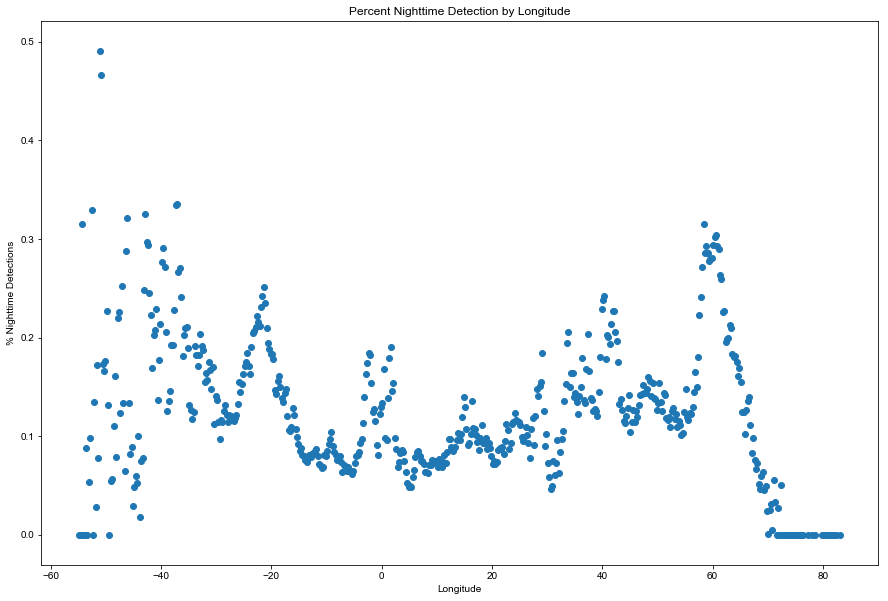

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
# plt.plot(lons, perc_night_lat)
ax.scatter(lons, perc_night_lat[:-1])
# ax.invert_xaxis()
plt.title('Percent Nighttime Detection by Longitude')
ax.set_xlabel('Longitude')
ax.set_ylabel('% Nighttime Detections')
plt.show()

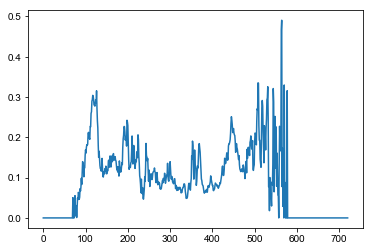

In [22]:
test = night_sum_lat.filled(0) / (night_sum_lat.filled(0) + day_sum_lat.filled(0))
test_ma = np.ma.MaskedArray(test, mask=np.isnan(test))
plt.plot(test_ma.filled(0))

## aggregate

In [23]:
days_fl, nights_fl=[],[]
day_an_agg, night_an_agg = [],[]
agg = 4
for year in range(2003,2019):

    day_files = glob(raster_folder + f'{var}/*_D_*{year}.tif')
    night_files = glob(raster_folder + f'{var}/*_N_*{year}.tif')
    
    day_arr,_ = es_stack(day_files, nodata=-32768)
    night_arr, _ = es_stack(night_files, nodata=-32768)
    op_oc = np.ma.masked_equal(op_0_25*365.25/2, 0) # annual overpass average
    
    day_arr/=op_oc
    night_arr/=op_oc
    
    arr_list = []
    if agg > 1:
        
        arr_list = []
        for a in day_arr:
            a[a.mask] = 0
            temp = block_reduce(a, (agg, agg), func=np.ma.sum)
            arr_list.append(np.ma.masked_equal(temp, 0))
            
        day_arr = np.array(arr_list)
        
        arr_list = []
        for a in night_arr:
            a[a.mask] = 0
            temp = block_reduce(a, (agg, agg), func=np.ma.sum)
            arr_list.append(np.ma.masked_equal(temp, 0))
            
        night_arr = np.array(arr_list)
    
    day_an_agg.append(day_arr)
    night_an_agg.append(night_arr)
    
    continue

In [24]:
day_sum_agg = np.ma.concatenate(day_an_agg, axis=0).sum(axis=0)
night_sum_agg = np.ma.concatenate(night_an_agg, axis=0).sum(axis=0)
perc_day_total_agg = day_sum_agg / (day_sum_agg + night_sum_agg)
perc_night_total_agg = night_sum_agg / (day_sum_agg + night_sum_agg)

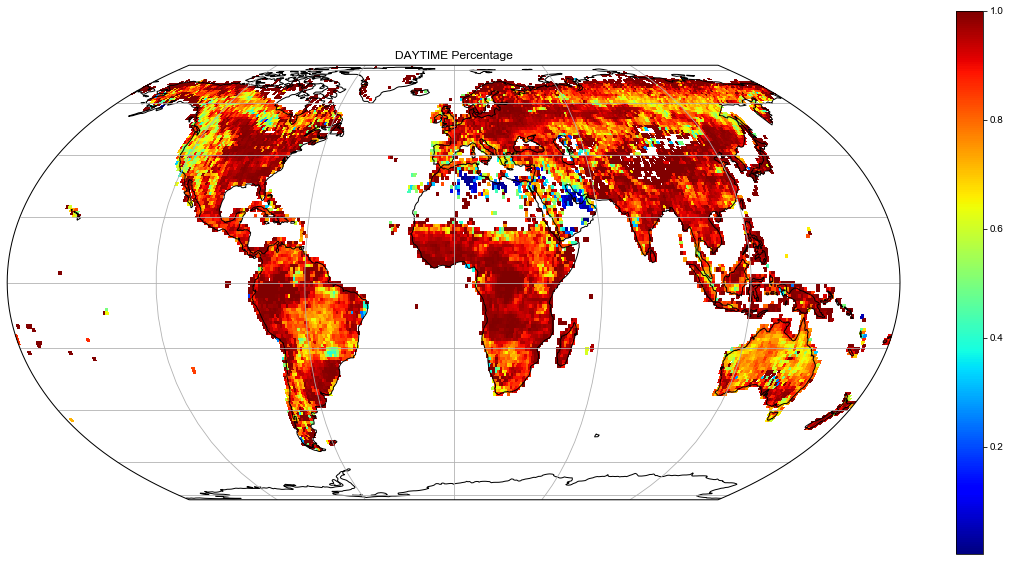

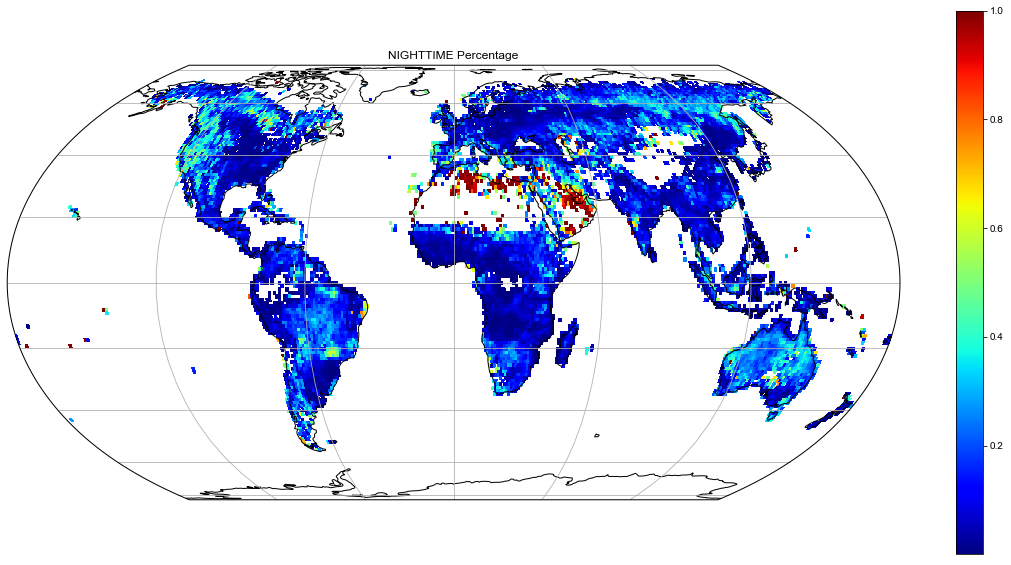

In [25]:
gen_plot_xarr(perc_day_total_agg, raster_folder, title='DAYTIME Percentage', agg=agg);
gen_plot_xarr(perc_night_total_agg, raster_folder, title='NIGHTTIME Percentage', agg=agg);


In [26]:
# fn = r'D:\projects\RD\night_fire\figs\global\AGG_1deg_SOLARELEV_nocorn_perc_night_total.tif'
# write_out_agg(perc_night_total_agg, fn, 'climate_grid_meta_0_25_wgs84.pickle', agg=1.0)

# fn = r'D:\projects\RD\night_fire\figs\global\AGG_1deg_SOLARELEV_nocorn_perc_day_total.tif'
# write_out_agg(perc_day_total_agg, fn, 'climate_grid_meta_0_25_wgs84.pickle', agg=1.0)

## summarize by longitude

In [27]:
day_sum_lat_agg = day_sum_agg.filled(0).sum(axis=1)
night_sum_lat_agg = night_sum_agg.filled(0).sum(axis=1)

# day_sum_lat_agg = np.ma.sum(day_sum_agg, axis=1)
# night_sum_lat_agg = np.ma.sum(night_sum_agg, axis=1)

perc_night_lat_agg = night_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
perc_night_lat_agg = np.ma.MaskedArray(perc_night_lat_agg, mask=np.isnan(perc_night_lat_agg))

perc_day_lat_agg = day_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
perc_day_lat_agg = np.ma.MaskedArray(perc_day_lat_agg, mask=np.isnan(perc_day_lat_agg))

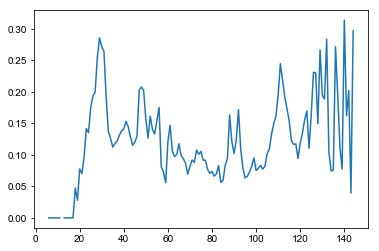

In [28]:
plt.plot(perc_night_lat_agg)

In [29]:
np.ma.mean(perc_night_lat_agg), np.ma.mean(perc_night_lat)

(0.12263595194056415, 0.12576021162491272)

In [30]:
lons_agg = np.arange(tform.f + tform.e*agg , -tform.f+ tform.e*agg, tform.e*agg) 
print(lons_agg.max(), lons_agg.min())

lons_agg=lons_agg[..., np.newaxis]
perc_night_lat_agg=perc_night_lat_agg[...,np.newaxis]

88.875 -90.125


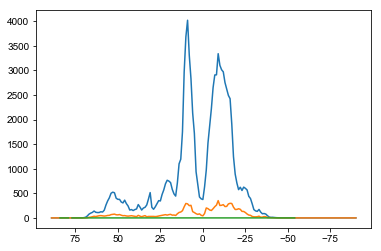

Text(0, 0.5, '% Nighttime Detections')

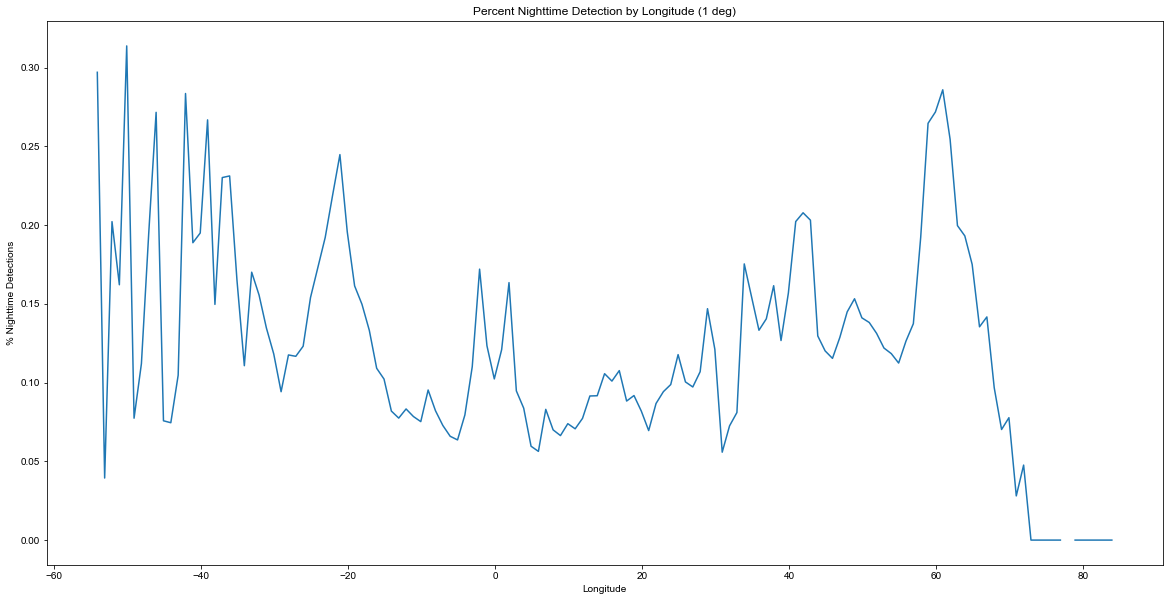

In [31]:
fig, ax = plt.subplots()
ax.plot(lons_agg, day_sum_lat_agg[1:])
ax.plot(lons_agg, night_sum_lat_agg[1:])
night_perc_agg = night_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
ax.plot(lons_agg, night_perc_agg[1:])
ax.invert_xaxis()
plt.show()


fig, ax = plt.subplots(figsize=(20,10))
night_perc_agg = night_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
ax.plot(lons_agg, night_perc_agg[1:])
# ax.invert_xaxis()
plt.title('Percent Nighttime Detection by Longitude (1 deg)')
ax.set_xlabel('Longitude')
ax.set_ylabel('% Nighttime Detections')

Text(0, 0.5, '% Nighttime Detections')

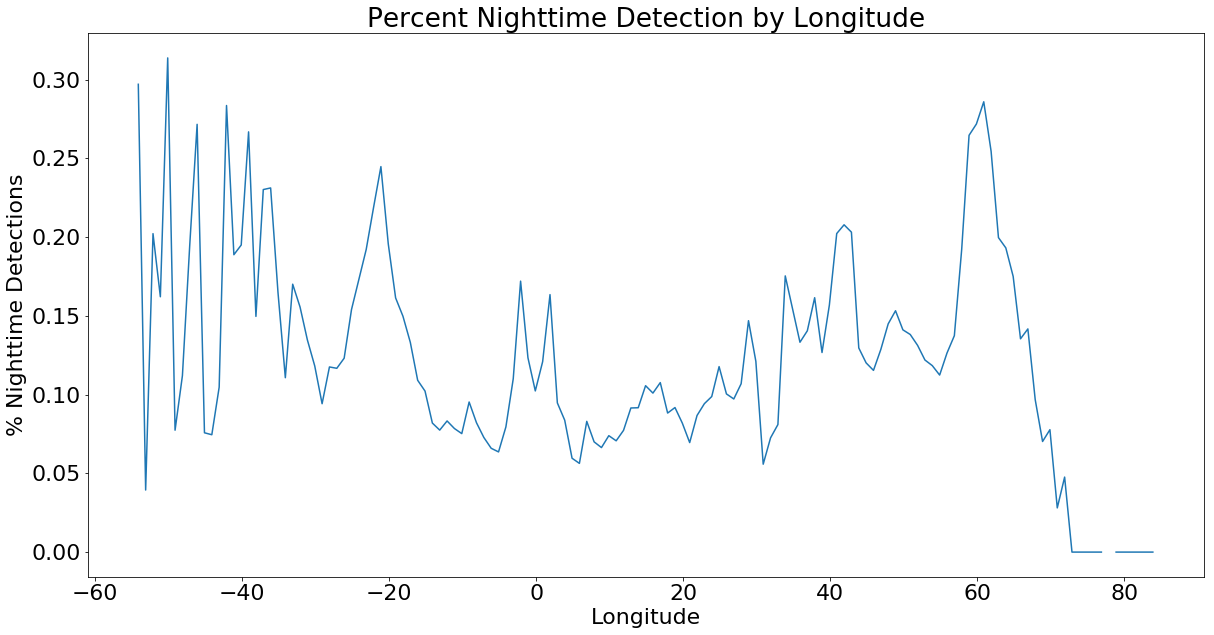

In [32]:
rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 22}

matplotlib.rc('font', **font)

night_perc_agg = night_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)
day_perc_agg = day_sum_lat_agg / (day_sum_lat_agg + night_sum_lat_agg)

d_10 = np.percentile(day_sum_agg, 10, axis=1) 
d_90 = np.percentile(day_sum_agg, 90, axis=1) 
n_10 = np.percentile(night_sum_agg, 10, axis=1) 
n_90 = np.percentile(night_sum_agg, 90, axis=1) 
#print(d_10, d_90, n_10, n_90)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(lons_agg, night_perc_agg[1:], label='Night')
# ax.plot(lons_agg, day_perc_agg[1:], label='Night')
# ax.invert_xaxis()
plt.title('Percent Nighttime Detection by Longitude')
ax.set_xlabel('Longitude')
ax.set_ylabel('% Nighttime Detections')

In [33]:
print(agg)

data = perc_night_total_agg
agg_fact=agg
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta

tform = meta['transform']
#num_x = meta['width']
#num_y = meta['height']

num_x = data.shape[1]
num_y = data.shape[0]

# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a*agg_fact, tform.c+num_x*tform.a*agg_fact, num_x)
tlat = np.linspace(tform.f - tform.e*agg_fact, tform.f+num_y*tform.e*agg_fact, num_y)
lon2d, lat2d = np.meshgrid(tlon, tlat)


# make data into xarray with location
xdata = xr.DataArray(data, coords=[tlat, tlon], dims=['lat', 'lon'])
xdata = xr.where(xdata == 0, np.nan, xdata)

4


In [34]:
print(agg)

data = perc_night_total_agg
agg_fact=agg
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta

tform = meta['transform']
#num_x = meta['width']
#num_y = meta['height']

num_x = data.shape[1]
num_y = data.shape[0]

# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a*agg_fact, tform.c+num_x*tform.a*agg_fact, num_x)
tlat = np.linspace(tform.f - tform.e*agg_fact, tform.f+num_y*tform.e*agg_fact, num_y)
lon2d, lat2d = np.meshgrid(tlon, tlat)


# make data into xarray with location
xdata = xr.DataArray(data, coords=[tlat, tlon], dims=['lat', 'lon'])
xdata = xr.where(xdata == 0, np.nan, xdata)

4


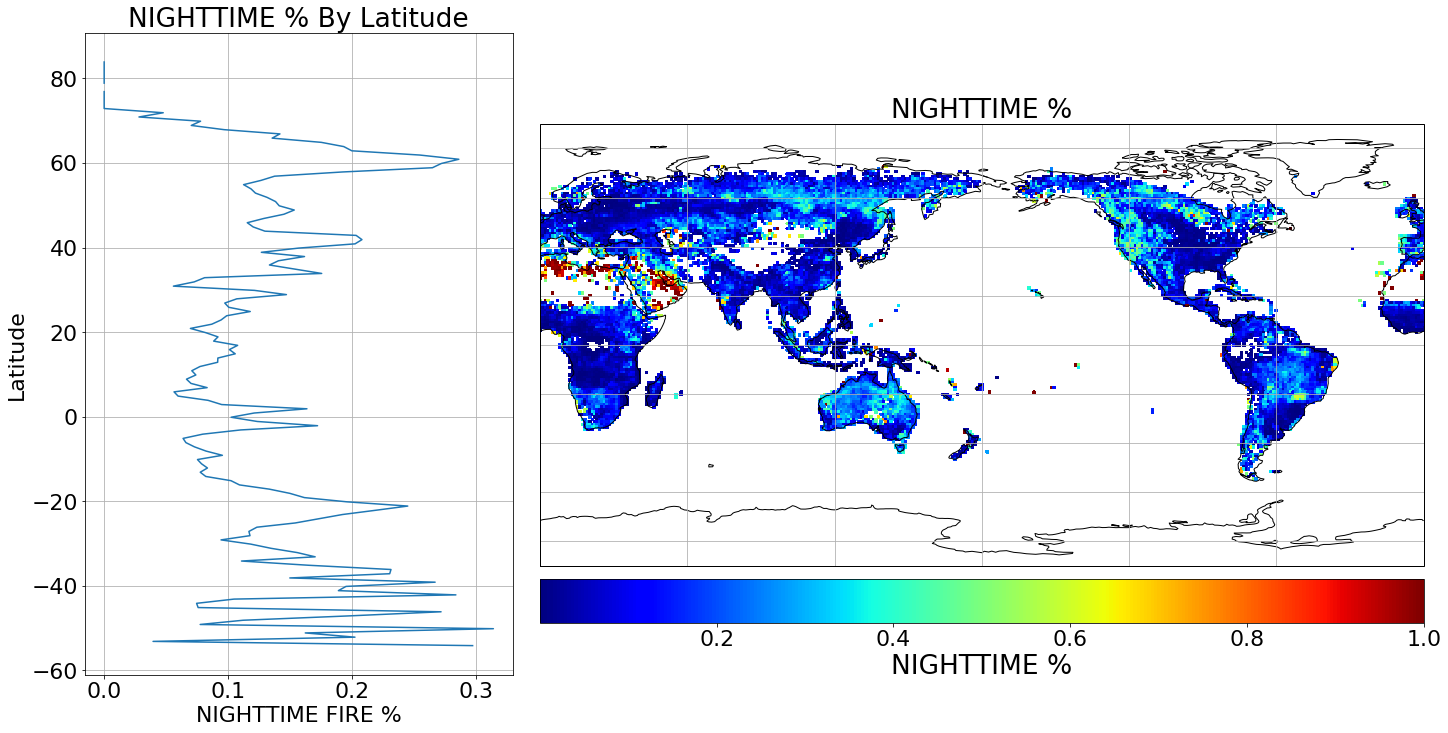

In [35]:
### using subplots
fig = plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.plot(night_perc_agg[1:], lons_agg, label='Night')
plt.grid(True)
plt.tight_layout()
plt.xlabel('NIGHTTIME FIRE %')
plt.ylabel('Latitude')
plt.title('NIGHTTIME % By Latitude')

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
ax = plt.subplot(1,3,(2,3), projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()
ax.coastlines()
ax.gridlines()
cf4 = xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet', add_colorbar=False)
ax.set_title('NIGHTTIME %')
cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02)
cb4.set_label('NIGHTTIME %', size='large')

plt.savefig('C:/users/jomc9287/desktop/test2.png', dpi=300)
plt.show()

In [36]:
from scipy.signal import spline_filter, medfilt

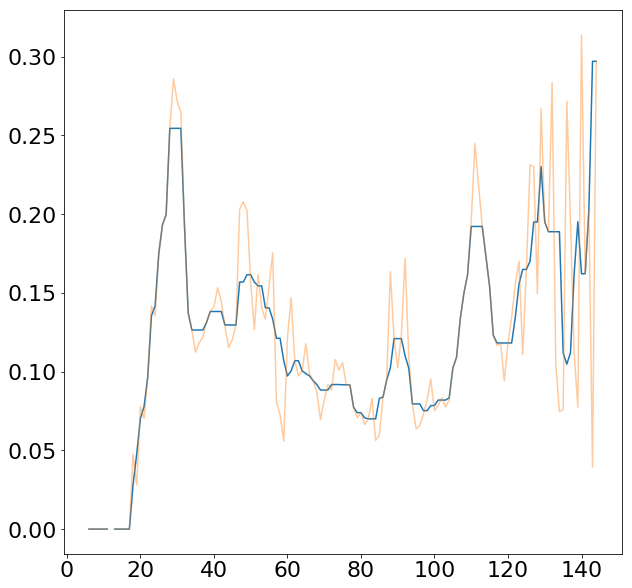

In [37]:
sm_perc = medfilt(perc_night_lat_agg.squeeze(), 7)
sm_perc = np.ma.MaskedArray(sm_perc, mask=perc_night_lat_agg.mask)
plt.plot(sm_perc)
plt.plot(perc_night_lat_agg, alpha=0.4)
plt.show()

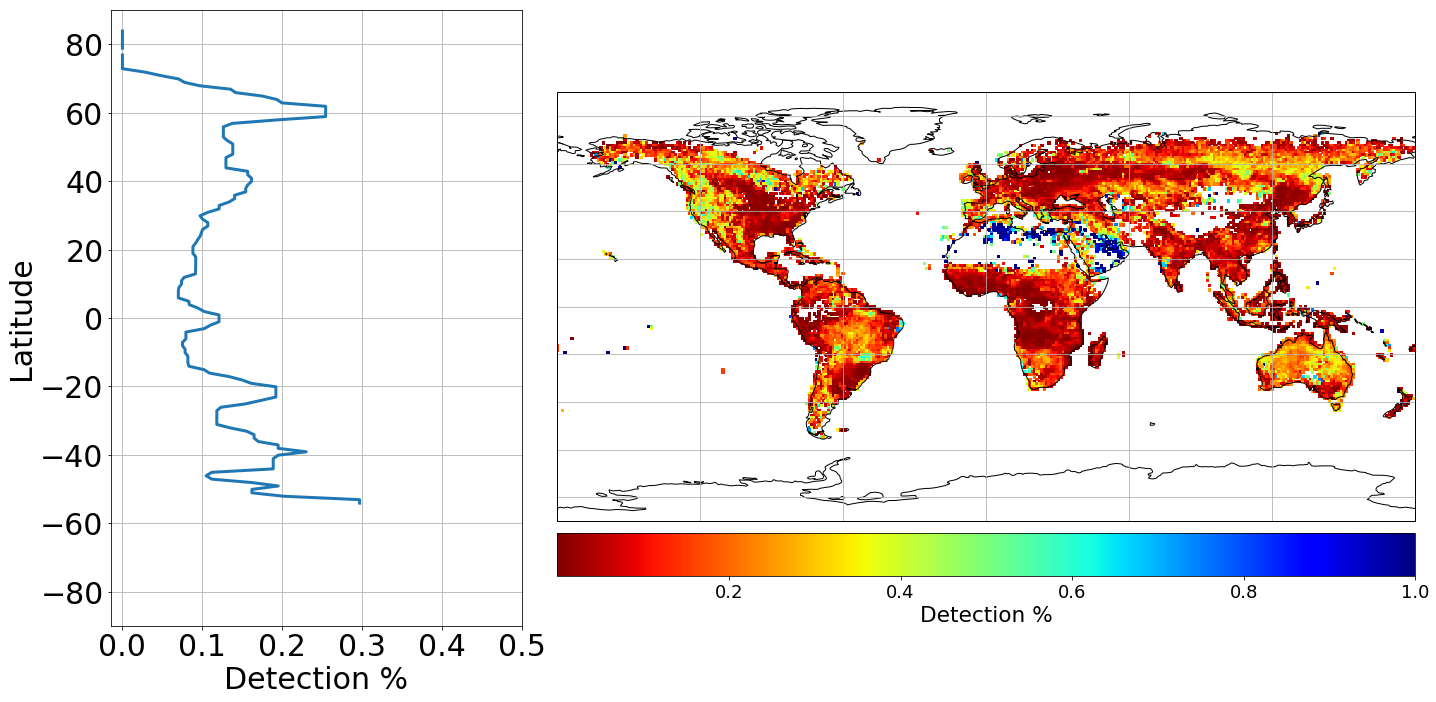

In [38]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 30}

matplotlib.rc('font', **font)

### using subplots
fig = plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.plot(sm_perc[1:], lons_agg, label='Night', linewidth=3)
plt.grid(True)
plt.tight_layout()
plt.ylim(-90,90)
xticks = list(np.arange(0.0,0.6,0.1))
plt.xticks(xticks)
plt.xlabel('Detection %')
plt.ylabel('Latitude')
# plt.title('NIGHTTIME % By Latitude')

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
ax = plt.subplot(1,3,(2,3), projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()
ax.gridlines()
cf4 = xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet_r', add_colorbar=False)
# ax.set_title('NIGHTTIME %')
cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02)
cb4.set_label('Detection %', size='large')

plt.savefig('C:/users/jomc9287/desktop/test2.png', dpi=300)
plt.show()

## mask with Koppen Landcover

In [39]:
kop_codes = '../KOPPEN/zero-goes-af-vpd-thresholds-with-landcover-codes.csv'
kop_ras = '../KOPPEN/lc_koppen_2010_mode.tif'

kop_ds = xr.open_rasterio(kop_ras)
kop_df = pd.read_csv(kop_codes)

In [40]:
bool_cube = []
for v in kop_df.koppen_modis_code.astype('float'):
    _t = xr.where(kop_ds == v, 1, 0)
    bool_cube.append(_t)
    


In [41]:
kop_mask = xr.concat(bool_cube).values.squeeze().any(axis=0)
kop_mask_agg = block_reduce(kop_mask, (agg, agg), func=np.ma.max, cval=0)
gl_nc = xdata.values.copy()

kop_mask_agg.shape, gl_nc.shape

((181, 360), (181, 360))

In [42]:
gl_nc_mask = gl_nc*kop_mask_agg
gl_nc_mask.shape

(181, 360)

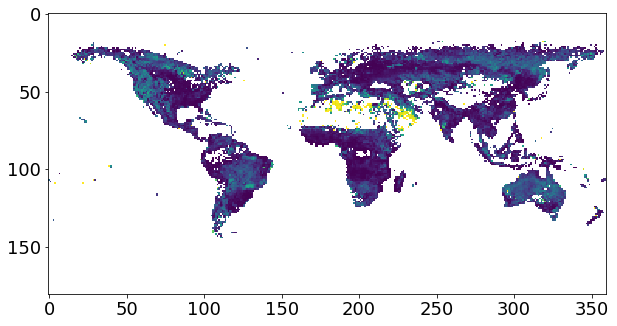

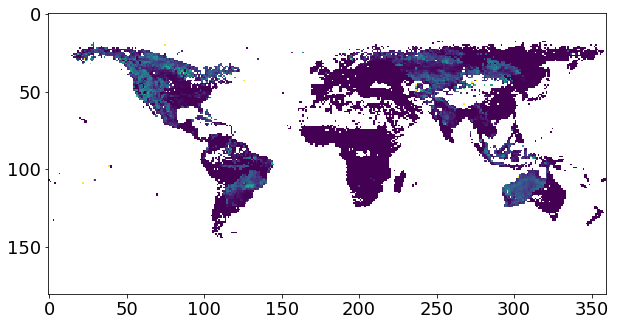

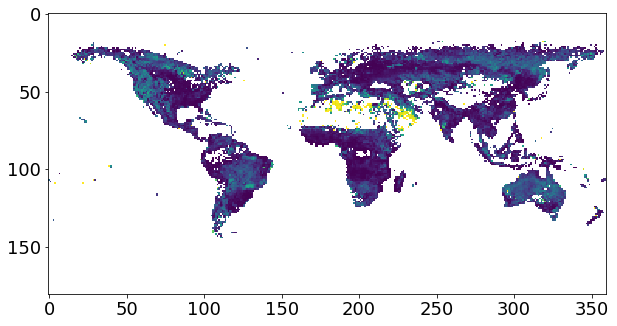

In [43]:
plt.imshow(gl_nc)
plt.show()
plt.imshow(gl_nc_mask)
plt.show()
plt.imshow(xdata.values)

In [44]:
np.nansum(xdata.values - gl_nc_mask)

1180.988

In [45]:
xdata_gl = xdata.copy()

roll_fact = int(np.floor(kop_mask_agg.shape[1]/2))
rolled_kop_mask = np.roll(kop_mask_agg, roll_fact, axis=1)
xdata_gl.values = gl_nc_mask # this one should be better...
xdata_gl.values = xdata.values*rolled_kop_mask # this one should be better...

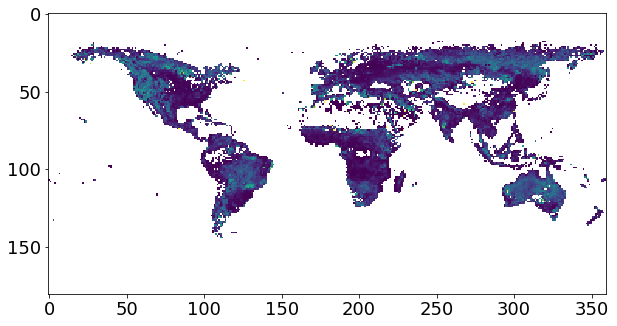

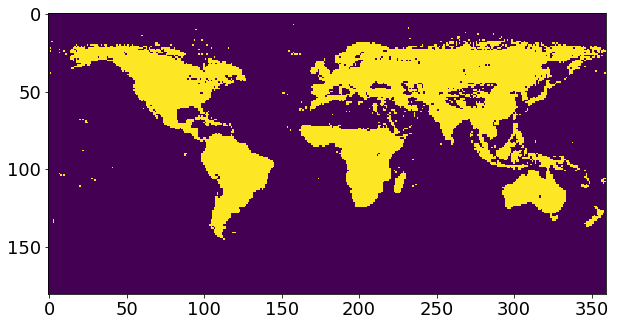

In [46]:
plt.imshow(xdata_gl.values)
plt.show()
plt.imshow(rolled_kop_mask)
plt.show()


## plot only with map, no grid lines, and colorbar a la John A.

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99] (100,)


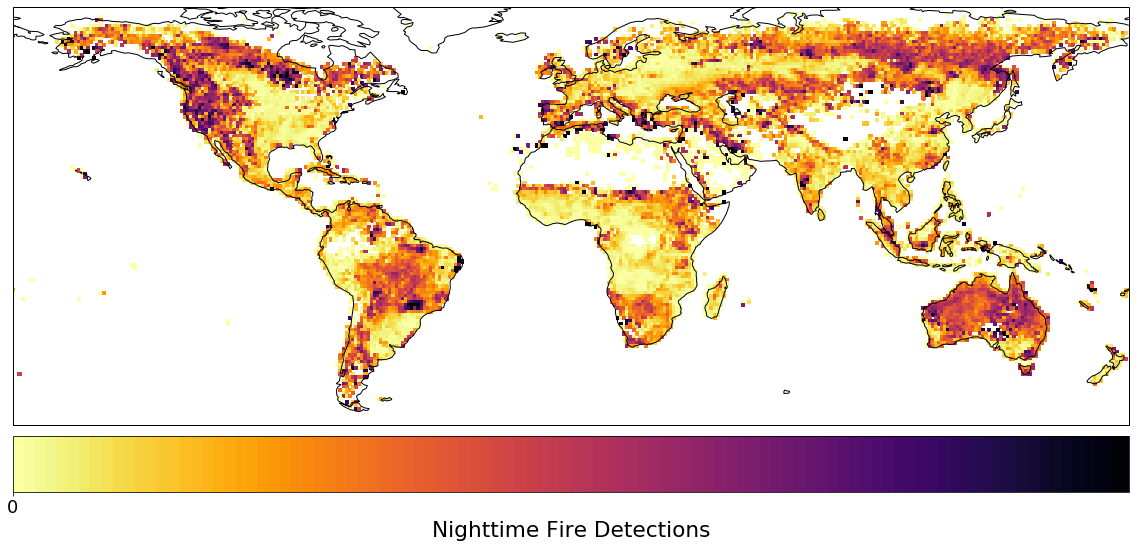

In [47]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()


#del cmap
# try function
c = 'viridis_r'
c = 'inferno_r'
#cmap, bounds = discrete_cmap(20, c)

base = plt.cm.get_cmap(c)
z_t_1_fact = 0.01
bounds = np.arange(0,1,z_t_1_fact)
print(bounds, bounds.shape)
color_list = base(bounds)
N = bounds.shape[0]
cmap_name = base.name + str(N)

# if  'viridis' in c:
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)
# else:
#     cmap = base.from_list(cmap_name, color_list, N)
    
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)


# cf4 = xdata_gl.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
cf4 = xdata_gl.plot(ax=ax, vmax=0.6, transform=ccrs.PlateCarree(), cmap=cmap,  add_colorbar=False, extend='neither')
ax.set_ylim(-60, 75)

# ax.set_title('NIGHTTIME %')

# cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
#                    boundaries=bounds,
#                    cmap=cmap,
#                    norm=norm,
#                    ticks=bounds)
cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                   cmap=cmap,
                   ticks=bounds*100, #x100 for percent
                  extend='neither')

if bounds.shape[0] > 10:
       
    n = 7  # Keeps every 7th label
    [l.set_visible(False) for (i,l) in enumerate(cb4.ax.xaxis.get_ticklabels()) if i % n != 0]
    
cb4.set_label('Nighttime Fire Detections', size='large')

plt.savefig(f'C:/users/jomc9287/desktop/final_test_gldasmask_burnable_{c}_koppen.png', dpi=300)
plt.show()



[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99] (100,)


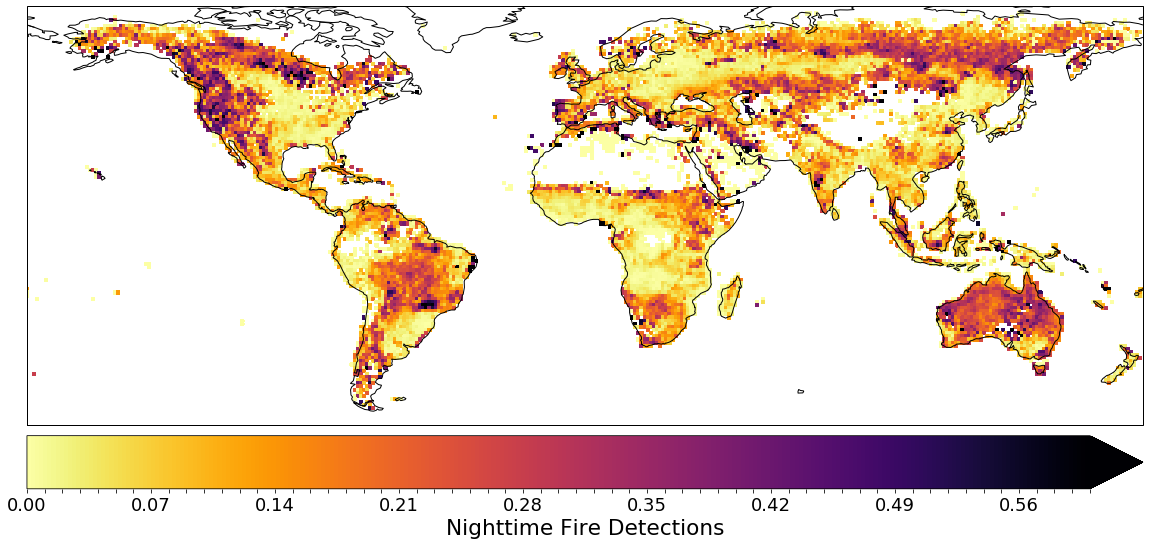

In [48]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()


#del cmap
# try function
c = 'viridis_r'
c = 'inferno_r'
#cmap, bounds = discrete_cmap(20, c)

base = plt.cm.get_cmap(c)
z_t_1_fact = 0.01
bounds = np.arange(0,1,z_t_1_fact)
print(bounds, bounds.shape)
color_list = base(bounds)
N = bounds.shape[0]
cmap_name = base.name + str(N)

# if  'viridis' in c:
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)
# else:
#     cmap = base.from_list(cmap_name, color_list, N)
    
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)


# cf4 = xdata_gl.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
cf4 = xdata_gl.plot(ax=ax, vmax=0.6, transform=ccrs.PlateCarree(), cmap='inferno_r',  add_colorbar=False, extend='max')
ax.set_ylim(-60, 75)

# ax.set_title('NIGHTTIME %')

# cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
#                    boundaries=bounds,
#                    cmap=cmap,
#                    norm=norm,
#                    ticks=bounds)

# cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
#                    cmap=cmap,
#                    ticks=bounds,
#                   extend='max')

cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02,
                  extend='max',
                  ticks=bounds[bounds<=0.6]) #x100 for percent

if bounds.shape[0] > 10:
       
    n = 7  # Keeps every 7th label
    [l.set_visible(False) for (i,l) in enumerate(cb4.ax.xaxis.get_ticklabels()) if i % n != 0]
    
cb4.set_label('Nighttime Fire Detections', size='large')

plt.savefig(f'C:/users/jomc9287/desktop/final_test_koppenmask_burnable_{c}.png', dpi=300)
plt.show()

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.] (100,)


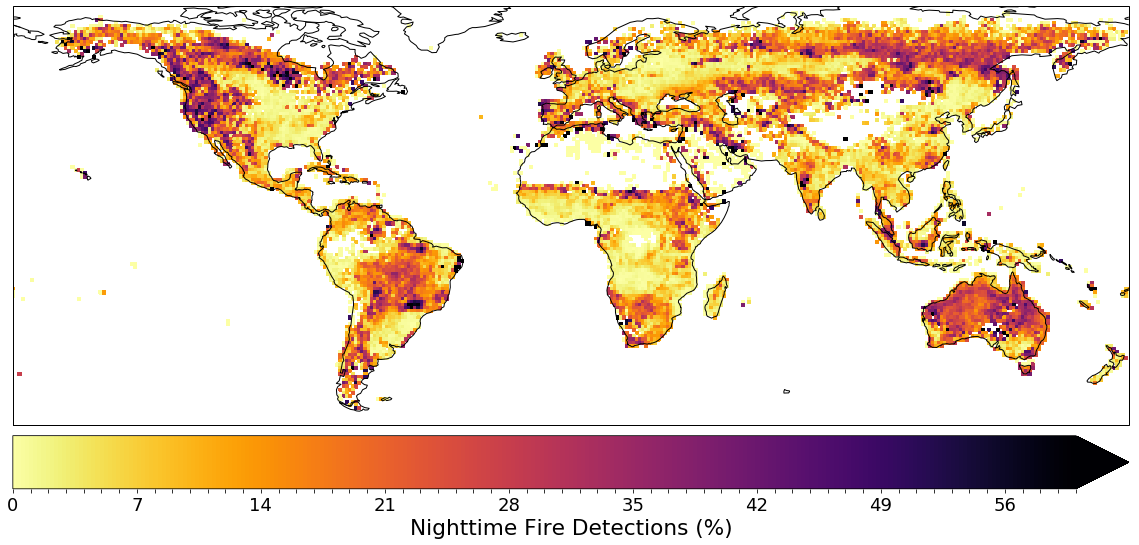

In [49]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype']=42

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()


#del cmap
# try function
c = 'viridis_r'
c = 'inferno_r'
#cmap, bounds = discrete_cmap(20, c)

base = plt.cm.get_cmap(c)
z_t_1_fact = 0.01
z_t_1_fact = 1.0 # for percentage
bounds = np.arange(0,1,z_t_1_fact)
bounds = np.arange(0,100,z_t_1_fact) # for percentage
print(bounds, bounds.shape)
color_list = base(bounds)
N = bounds.shape[0]
cmap_name = base.name + str(N)

# if  'viridis' in c:
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)
# else:
#     cmap = base.from_list(cmap_name, color_list, N)
    
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)


# cf4 = xdata_gl.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
xdata_gl *=100 # for percentage
cf4 = xdata_gl.plot(ax=ax, vmax=60., transform=ccrs.PlateCarree(), cmap='inferno_r',  add_colorbar=False, extend='max')
ax.set_ylim(-60, 75)

# ax.set_title('NIGHTTIME %')

# cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
#                    boundaries=bounds,
#                    cmap=cmap,
#                    norm=norm,
#                    ticks=bounds)

# cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
#                    cmap=cmap,
#                    ticks=bounds,
#                   extend='max')

cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02,
                  extend='max',
                  ticks=bounds[bounds<=60.]) #x100 for percent

if bounds.shape[0] > 10:
       
    n = 7  # Keeps every 7th label
    [l.set_visible(False) for (i,l) in enumerate(cb4.ax.xaxis.get_ticklabels()) if i % n != 0]
    
cb4.set_label('Nighttime Fire Detections (%)', size='large')

plt.savefig(f'C:/users/jomc9287/desktop/final_percentage_test_koppenmask_burnable_{c}.pdf', dpi=300)
plt.show()

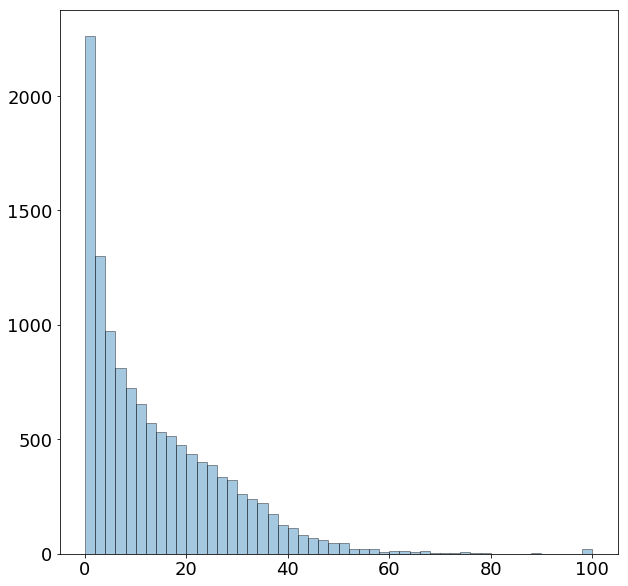

In [50]:
plt.hist(xdata_gl.values.ravel(), bins=50, alpha=0.4, edgecolor='k')
plt.show()

In [51]:
import rioxarray as rxr

In [52]:
xdata_gl.rio.write_crs(4326).rio.set_spatial_dims('lon', 'lat').rio.to_raster('fig1_night_afc_summary_geo.tif')